In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## EDA 분석
문서 이미지 분류 CV EDA는 스캔 품질, 종이 상태, 회전, 손상, OCR 인식 가능성 같은 문서 특유의 노이즈 성능에 영향을 줍니다.

### 1️⃣ 클래스 분포 (Imbalance 확인) : Macreo F!이 평가지표이며, 해당 평가지표는 Imbalance에 민감.
- train.csv에서 target별 분포 파악.
- Bar chart로 클래스별 개수 비교.
- 일부 희귀 클래스가 있다면 oversampling/undersampling 필요 여부 판단.


### 2️⃣ 이미지 해상도, 종횡비 분석
- 모든 이미지의 (Width, Height) 저장.
- Min, Max, Mean, Std 확인.
- 너무 작은 이미지 있으면 OCR 누락 가능성, 너무 큰 이미지 있으면 resize 정책 검토.
    ✅ 문서 스캔본은 종종 크기가 제각각임.

### 3️⃣ 샘플 이미지 시각화
- 각 클래스별로 대표 샘플 5~10장씩 랜덤으로 그리드 출력.
- 회전, 빛 번짐, 종이 구김 등 노이즈가 보이는지 확인.
    ✅ 실제 Augraphy/Albumentations 증강 전략에 영향.

### 4️⃣ Rotation/Flip 패턴 체크
- 일부 이미지가 90°, 180° 회전되어 있을 수 있음.
- Test셋에 rotation noise가 포함돼 있다면 학습셋에도 강한 rotation 증강 필요.

### 5️⃣ Noise & Blur 탐지
- 이미지 sharpness 분포 간단히 확인.
- OpenCV의 cv2.Laplacian으로 Blur Score 확인.
- 빛 번짐, 스캔 자국, 스탬프/필기 있는지.
    ✅ Augraphy로 같은 패턴 재현 가능.

### 6️⃣ 클래스별 시각적 유사도 확인
- 혼동될 가능성이 있는 클래스(예: 운전면허증 vs 주민등록증) 비교 시각화.
- 최종 Confusion Matrix 분석 포인트 미리 찾기.
    ✅ 이후 Hard Negative Mining에도 도움.

### ✅ 추천 추가: Augraphy 증강 후보 선정
- EDA에서 찾은 Rotation/Noise → 증강 파이프라인 설계에 반영
- 문서 특화 증강: 구김, Blur, InkBleed, Brightness variation, Folding 등


In [9]:
import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from tqdm import tqdm
from PIL import Image, ImageStat
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from augraphy import AugraphyPipeline, Folding, InkBleed, Brightness, NoiseTexturize, PaperFactory

In [16]:
os.path.dirname(os.getcwd())

'/root/upstageailab-cv-classification-cv_7/Notebook'

In [17]:
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "../"))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
print(ROOT_DIR)


/root/upstageailab-cv-classification-cv_7


In [8]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, aug_pipeline=None, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.aug_pipeline = aug_pipeline

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))

        if self.aug_pipeline:
            img = self.aug_pipeline(img)

        if self.transform:
            img = self.transform(image=img)['image']
        return img, target, os.path.join(self.path, name)

In [39]:
from src.transform.custom_transform import get_augraphy_transform, get_transform_rotation, get_transform_gaussNoise, get_transform_blur, get_transform_shadow, get_test_transform

augraphy_transform = get_augraphy_transform()

In [41]:
trn_dataset = ImageDataset(
    csv="../../data/train.csv",
    path="../../data/train",
    aug_pipeline=augraphy_transform,
    transform=None
)

print(len(trn_dataset))

tst_dataset = ImageDataset(
    csv="../../data/sample_submission.csv",
    path="../../data/test",
    aug_pipeline=augraphy_transform,
    transform=None
)

print(len(tst_dataset))

1570
3140


In [6]:
trn_img, trn_target, trn_path = trn_dataset[0]
print("학습 데이터셋 크기:", trn_img.shape, trn_target)
print("이미지 파일 경로:", trn_path)

tst_img, tst_target, tst_path = tst_dataset[0]
print("평가 데이터셋 크기:", tst_img.shape, tst_target)
print("평가 이미지 경로:", tst_path)


학습 데이터셋 크기: (591, 443, 3) 16
이미지 파일 경로: ../../data/train/002f99746285dfdd.jpg
평가 데이터셋 크기: (591, 443, 3) 0
평가 이미지 경로: ../../data/test/0008fdb22ddce0ce.jpg


### 클래스 분포 확인

- account_number (계좌번호)
- application_for_payment_of_pregnancy_medical_e (임신의료비 지급신청서)
- car_dashboard (차량 대시보드)
- confirmation_of_admission_and_discharge (입퇴원 확인서)
- diagnosis (진단서)
- driver_licence (운전면허증)
- medical_bill_receipts (의료비 영수증)
- medical_outpatient_certificate (의료 외래 증명서)
- national_id_card (주민등록증)
- passport (여권)
- payment_confirmation (결제 확인서)
- pharmaceutical_receipt (약국 영수증)
- prescription (처방전)
- resume (이력서)
- statement_of_opinion (의견서)
- vehicle_registration_certificate (차량등록증)
- vehicle_registration_plate (차량번호판)

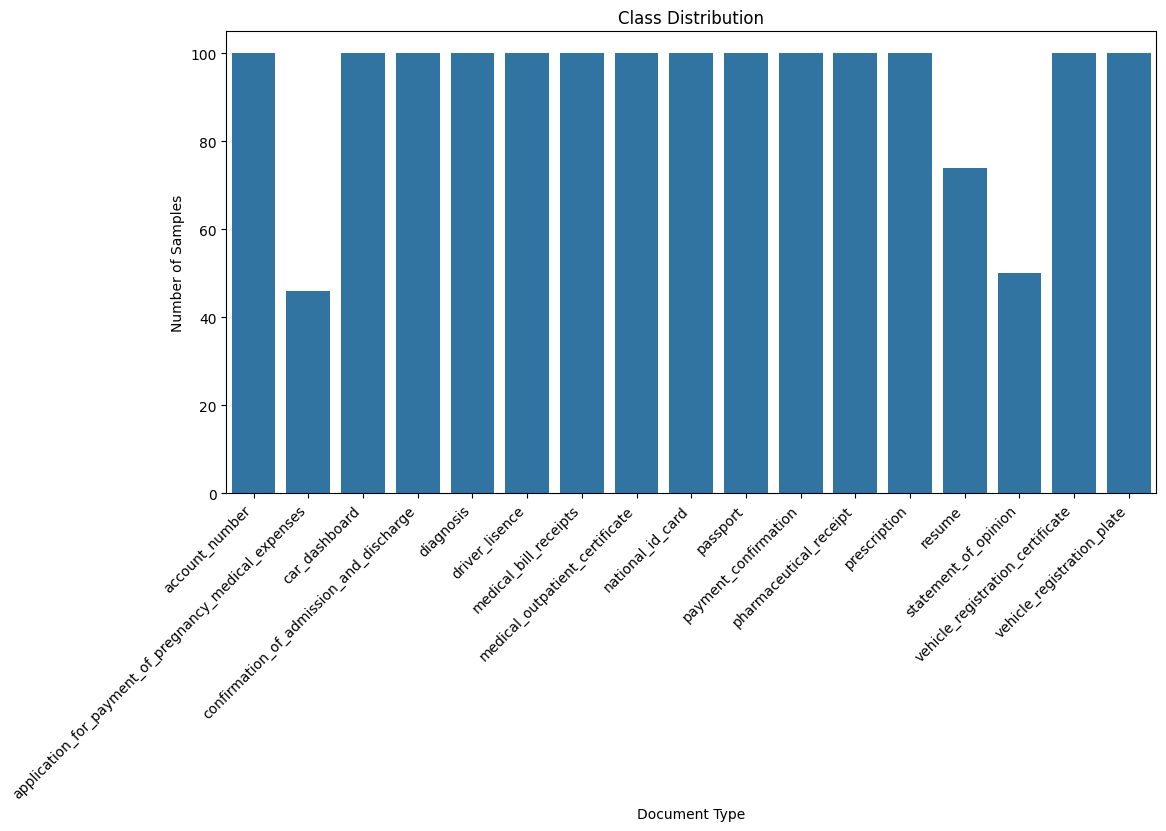

In [25]:
trn_df = pd.read_csv("../../data/train.csv")
meta_df = pd.read_csv("../../data/meta.csv")

class_counts = trn_df['target'].value_counts().sort_index()
class_names = meta_df.set_index('target').loc[class_counts.index]['class_name']

plt.figure(figsize=(12,6))
sns.barplot(x=class_names, y=class_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.xlabel('Document Type')
plt.ylabel('Number of Samples')
plt.show()

In [26]:
count_df= pd.DataFrame({
    'class_name': class_names.values,
    'count' : class_counts.values
})

print(count_df)

                                           class_name  count
0                                      account_number    100
1   application_for_payment_of_pregnancy_medical_e...     46
2                                       car_dashboard    100
3             confirmation_of_admission_and_discharge    100
4                                           diagnosis    100
5                                      driver_lisence    100
6                               medical_bill_receipts    100
7                      medical_outpatient_certificate    100
8                                    national_id_card    100
9                                            passport    100
10                               payment_confirmation    100
11                             pharmaceutical_receipt    100
12                                       prescription    100
13                                             resume     74
14                               statement_of_opinion     50
15                   veh

#### 클래스 분포
- 17개 중 14개 이미지 100개 샘플 보유. 
* 1   application_for_payment_of_pregnancy_medical_expenses:    46

* 13                                                 resume     74

* 14                                   statement_of_opinion     50

In [27]:
print(trn_df)
print(trn_df.columns)

                        ID  target
0     002f99746285dfdd.jpg      16
1     008ccd231e1fea5d.jpg      10
2     008f5911bfda7695.jpg      10
3     009235e4c9c07af5.jpg       4
4     00b2f44967580c74.jpg      16
...                    ...     ...
1565  fed9e9ec4a77bc06.jpg       4
1566  feeade617aa68c45.jpg       7
1567  ff51dd281a8423f1.jpg      11
1568  ff8a6a251ce51c95.jpg       5
1569  ffc22136f958deb1.jpg       9

[1570 rows x 2 columns]
Index(['ID', 'target'], dtype='object')


In [28]:
print(meta_df)
print(meta_df.columns)

    target                                         class_name
0        0                                     account_number
1        1  application_for_payment_of_pregnancy_medical_e...
2        2                                      car_dashboard
3        3            confirmation_of_admission_and_discharge
4        4                                          diagnosis
5        5                                     driver_lisence
6        6                              medical_bill_receipts
7        7                     medical_outpatient_certificate
8        8                                   national_id_card
9        9                                           passport
10      10                               payment_confirmation
11      11                             pharmaceutical_receipt
12      12                                       prescription
13      13                                             resume
14      14                               statement_of_opinion
15      

### test, train 데이터셋 각 샘플들 확인

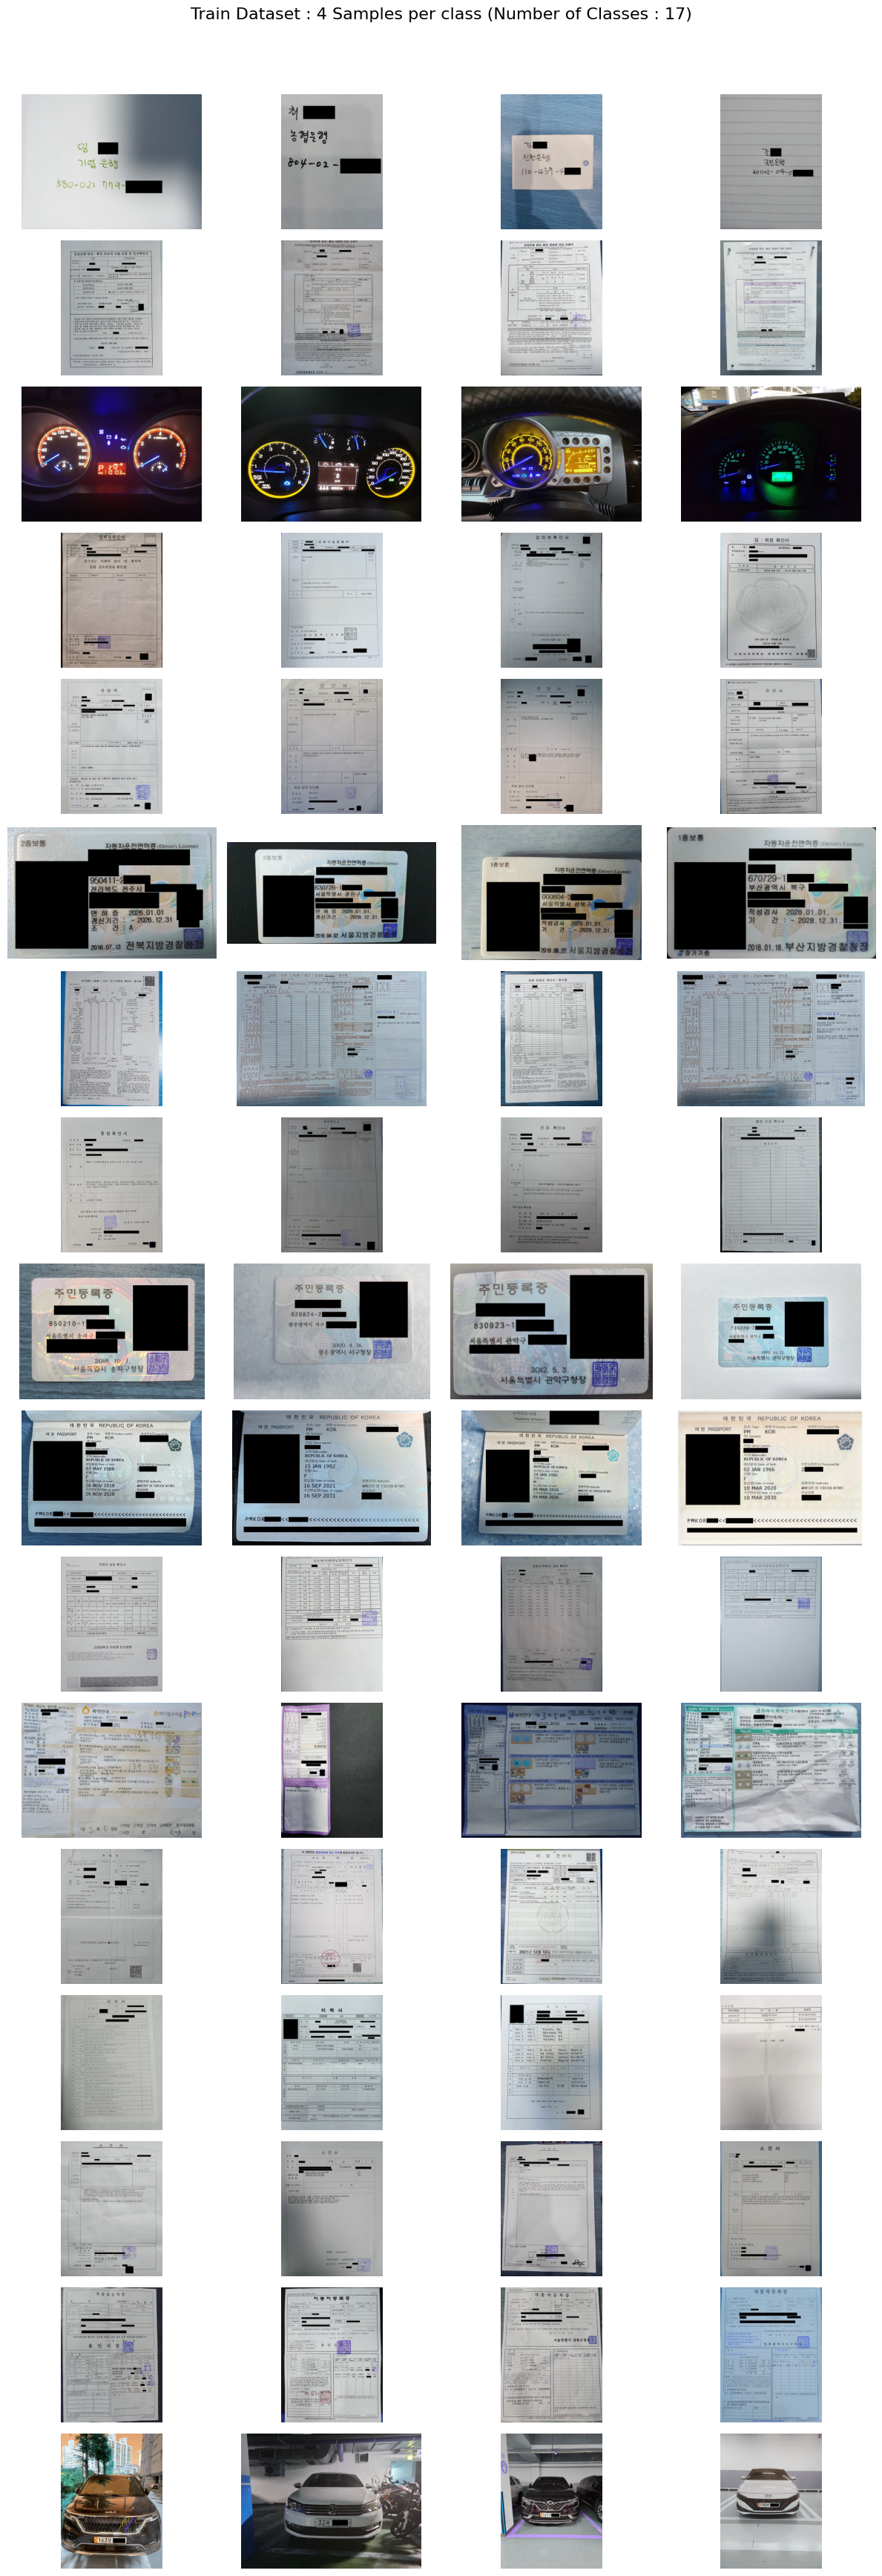

In [32]:
# train 데이터셋 17개 클래스의 각 샘플들 4가지 랜덤 출력
num_classes = trn_df['target'].nunique()
samples_per_class = 4

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class*3, num_classes*2))

for class_idx in range(num_classes):
    class_name = meta_df[meta_df['target']==class_idx]['class_name'].values[0]

    ids = trn_df[trn_df['target'] ==class_idx]['ID'].sample(samples_per_class, random_state=42).tolist()
    
    for i, img_id in enumerate(ids):
        ax = axes[class_idx, i]
        img = Image.open(os.path.join('../../data/train', img_id))
        ax.imshow(img)
        if i == 0:
            ax.set_ylabel(f"{class_idx}: {class_name}", rotation=0, labelpad=60, fontsize=8, va='center')
        ax.axis('off')

plt.suptitle("Train Dataset : 4 Samples per class (Number of Classes : 17)", fontsize=16, y=1.02)  # y 위치 조정으로 겹침 방지
plt.tight_layout()
plt.show()
    

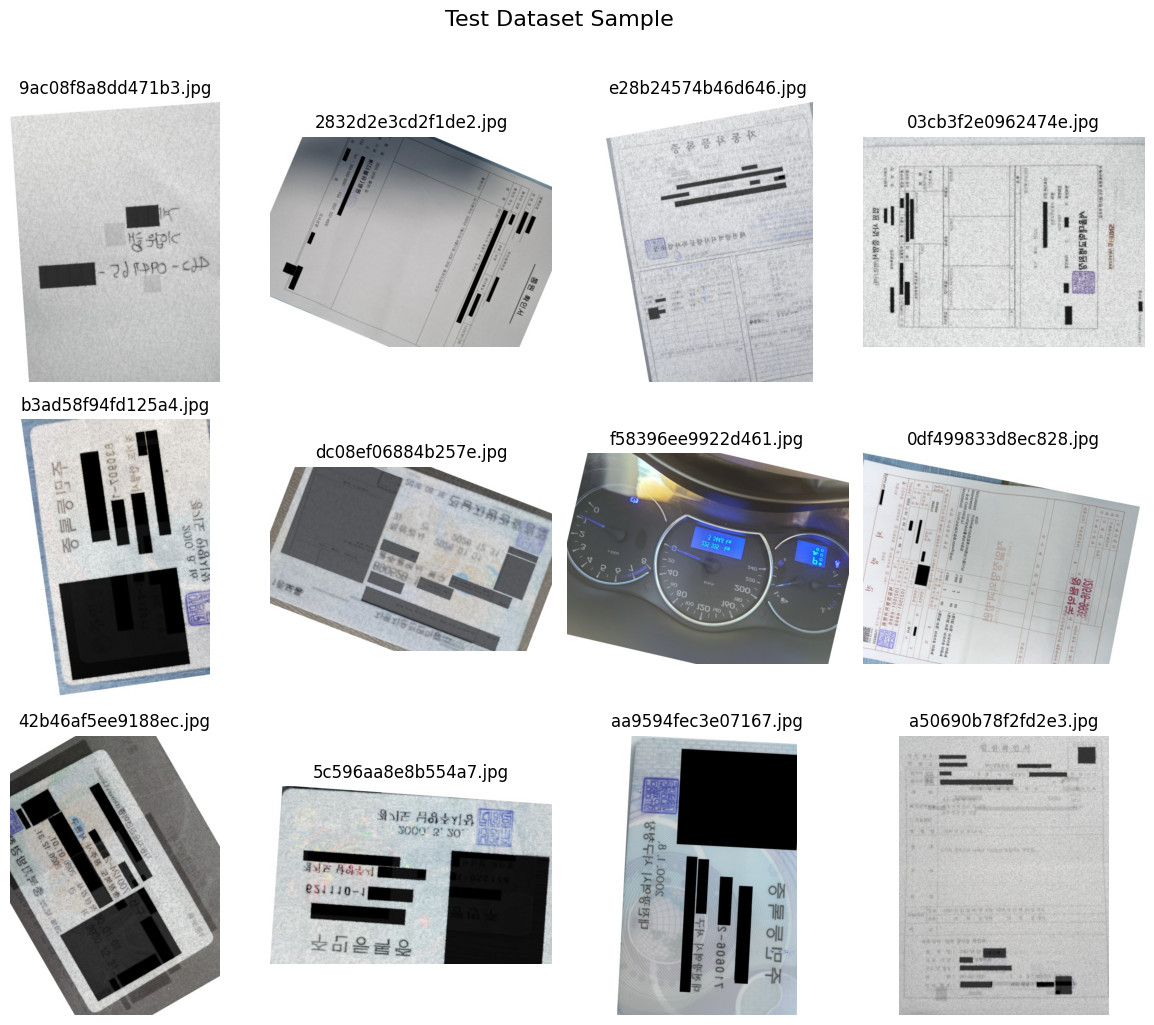

In [49]:
tst_df=pd.read_csv("../../data/sample_submission.csv")
sample_ids = random.sample(list(tst_df['ID']), 12)

plt.figure(figsize=(12,10))
for idx, img_id in enumerate(sample_ids):
    img = Image.open(os.path.join("../../data/test", img_id))
    plt.subplot(3,4, idx+1)
    plt.imshow(img)
    plt.title(f"{img_id}")
    plt.axis("off")
    
plt.suptitle("Test Dataset Sample", fontsize=16, y=1.02)  # y 위치 조정으로 겹침 방지
plt.tight_layout()
plt.show()

#### 문서 이미지 기술 통계
- 실제로 증강(Augraphy), 전처리 파이프라인 설계의 근거 데이터가 됨.
- 특히 rotation, blur, noise는 Test셋이 실제 현실 데이터라면 더 중요.

| Feature                        | 도출할 수 있는 결과 인사이트              | 실질적으로 취할 수 있는 전략                                             |
| ------------------------------ | ----------------------------- | ------------------------------------------------------------ |
| **`width`**                    | 가로 해상도 분포 → 작은 해상도 이미지 비율 확인  | 작은 이미지는 resize 시 픽셀 깨짐 위험 → 최소 해상도 threshold 정하거나 padding 사용 |
| **`height`**                   | 세로 해상도 분포 → 세로 길이 편차 확인       | 종횡비 균일화 → Resize 후 Aspect Ratio 유지 or Pad로 빈 공간 채움           |
| **`aspect_ratio`**             | 종횡비 왜곡 가능성 → 극단적인 비율 여부       | Aspect Ratio 보존 Resize / Warping 방지                          |
| **`channels`**                 | 흑백/컬러 혼합 여부 → RGB 채널 수 확인     | 흑백이면 ColorJitter 불필요, 컬러이면 색상 변환 증강 추가 가능                    |
| **`file_size_kb`**             | 파일 용량 분포 → 압축도 편차 파악          | 과도한 압축(용량 적음)은 화질 열화 위험 → 압축 artifacts 대응 증강                 |
| **`total_pixels`**             | 이미지 크기 총합 → 극단적 소형/대형 문서 탐지   | 대형은 다운스케일, 소형은 Upscale 시 품질 유지 증강 고려                         |
| **`brightness`**               | 밝기 평균 → 너무 어둡거나 밝은 문서 비율      | Brightness/Contrast 증강 범위 설정                                 |
| **`contrast`**                 | 대비 낮은 문서 비율                   | Contrast Limited Adaptive Histogram Equalization(CLAHE) 전처리  |
| **`sharpness`**                | Blur 심한 문서 탐지                 | Blur 증강 (Defocus) or 선명화(Sharpen) 필요성 결정                     |
| **`edge_ratio`**               | 문서 복잡도/경계 선명도 → 표/선 구조 비율     | 복잡한 문서는 더 높은 해상도 유지 필요, Simple은 압축 가능                        |
| **`b_mean` `g_mean` `r_mean`** | 평균 색상 → 컬러 균일성 확인             | 스캔 조명 영향 탐지, White Balance 전처리 고려                            |
| **`histogram_entropy`**        | 이미지 정보량 → 단조로운 배경/정보 많은 문서 구분 | Low Entropy → Adaptive Threshold / Binarization              |
| **`histogram_skewness`**       | 밝기 치우침 → 그림자, 빛 번짐 여부         | 그림자 제거 증강, 밝기 정규화                                            |
| **`histogram_kurtosis`**       | 피크/플랫 정도 → 극단적 contrast 여부    | Flat하면 가벼운 Enhance, High하면 노이즈 제거 주의                         |
| **`skew_angle`**               | 기울기 편향 → 스캔 잘못된 문서 비율         | Rotation 증강, 또는 Inference 전 Auto Deskew                      |
| **`white_space_ratio`**        | 빈 공간 비율 → 내용 밀도               | Margin Cut, Crop, OCR 영역 탐지시 Threshold 조정                    |
| **`noise_level`**              | 스캔 노이즈 강도 → 잡음 많은 문서 비율       | Noise Injection 증강 범위 결정                                     |
| **`jpeg_quality_estimate`**    | 압축 artifacts 심한 비율            | 압축 artifact 대응 증강(Augraphy), 원본 화질 관리 정책                     |



In [34]:
print('학습 데이터셋 샘플 개수 :', len(trn_df))
print(trn_df.head())

학습 데이터셋 샘플 개수 : 1570
                     ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16


In [44]:
trn_results = [] #기술 통계 저장용

for idx in tqdm(range(len(trn_dataset))):
    img, target, path = trn_dataset[idx]
    
    height, width, channels = img.shape
    aspect_ratio = width / height
    file_size_kb = os.path.getsize(path)/ 1024 #bytes->KB 변환
    
    total_pixels = width * height
    brightness = np.mean(img)
    contrast = np.std(img)
    #OpenCV로 Blur, Edge Ratio
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / total_pixels
    
    #RGB 채널 평균 (마지막 차원이 채널이기에 색깔 번호에 맞게)
    b_mean = np.mean(img[:,:,2])
    g_mean = np.mean(img[:,:,1])
    r_mean = np.mean(img[:,:,0])
    
    #히스토그램
    hist = cv2.calcHist([gray], [0], None, [256],[0,256]).flatten()
    hist_norm = hist/ hist.sum()
    hist_entropy = -np.sum([p*np.log2(p+1e-7) for p in hist_norm])
    hist_skewness = (np.mean((hist_norm - np.mean(hist_norm))**3))/(np.std(hist_norm)**3+ 1e-7)
    hist_kurtosis = (np.mean((hist_norm - np.mean(hist_norm))**4)) / (np.std(hist_norm)**4+ 1e-7)
    
    #Skew Angle 추정 
    coords = np.column_stack(np.where(gray <200))
    angle = 0
    if len(coords) >0:
        rect = cv2.minAreaRect(coords)
        angle = rect[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
            
    skew_angle = angle
    
    # white space ratio
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    white_pixels = np.sum(thresh == 255)
    white_space_ratio = white_pixels / total_pixels
    
    #Noise lebel
    h, w = gray.shape
    block_size = 32
    stds = []
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            block = gray[y: y+block_size, x:x+block_size]
            if block.size > 0:
                stds.append(np.std(block))
                
        noise_level = np.mean(stds)
        
    jpeg_quality_estimate = (hist_entropy * 0.5) / (sharpness + 1e-7)
    
    trn_results.append({
        'idx': idx,
        'width': width,
        'height': height,
        'channels': channels,
        'aspect_ratio': aspect_ratio,
        'total_pixels': total_pixels,
        'brightness': brightness,
        'contrast': contrast,
        'sharpness': sharpness,
        'edge_ratio': edge_ratio,
        'b_mean': b_mean,
        'g_mean': g_mean,
        'r_mean': r_mean,
        'histogram_entropy': hist_entropy,
        'histogram_skewness': hist_skewness,
        'histogram_kurtosis': hist_kurtosis,
        'skew_angle': skew_angle,
        'white_space_ratio': white_space_ratio,
        'noise_level': noise_level,
        'jpeg_quality_estimate': jpeg_quality_estimate
    })

# DataFrame으로 정리
trn_tech_df = pd.DataFrame(trn_results)
print(trn_tech_df.describe().transpose())
        
    
    
    
    

100%|██████████| 1570/1570 [01:18<00:00, 19.97it/s]

                        count           mean         std            min  \
idx                    1570.0     784.500000  453.364276       0.000000   
width                  1570.0     497.613376   79.370316     384.000000   
height                 1570.0     538.169427   76.074772     348.000000   
channels               1570.0       3.000000    0.000000       3.000000   
aspect_ratio           1570.0       0.970007    0.323053       0.563050   
total_pixels           1570.0  261779.949682  120.726659  261184.000000   
brightness             1570.0     205.550262   42.123294      26.695369   
contrast               1570.0      54.603391   25.003126      12.307007   
sharpness              1570.0     719.430941  566.448788      41.417008   
edge_ratio             1570.0       0.085523    0.067168       0.001948   
b_mean                 1570.0     206.360550   42.431743      19.685898   
g_mean                 1570.0     205.485122   42.596736      18.933689   
r_mean                 15

### 기술 통계를 통한 인사이트 도출
#### 해상도 & 종횡비
| 항목                | 값                             | 인사이트                    | 전략                              |
| ----------------- | ----------------------------- | ----------------------- | ------------------------------- |
| **width**         | 평균 497px (min 384 \~ max 753) | 해상도가 꽤 작음 → 작은 문서 품질 주의 | 너무 작은 건 Upscale, Resize+Padding |
| **height**        | 평균 538px (min 348 \~ max 682) | 세로는 좀 긴 편               | Aspect Ratio 보존 중요              |
| **aspect\_ratio** | 평균 0.97, max 2.16             | 종횡비 분산 있음 (긴 문서 있음)     | 비율 보존 Resize → Pad로 채워야 왜곡 방지   |

#### 밝기/ 대비 품질
| 항목              | 값                           | 인사이트              | 전략                      |
| --------------- | --------------------------- | ----------------- | ----------------------- |
| **brightness**  | 평균 148.4, min 17.5, max 211 | 일부 굉장히 어두운 문서 있음  | 밝기 정규화 증강 필요            |
| **contrast**    | 평균 48.1, min 10.5           | 낮은 대비 → 흐릿한 스캔 있음 | CLAHE 적용 고려             |
| **b/g/r_mean** | 146\~149 범위                 | 컬러 불균형 크지 않음      | White Balance는 크게 필요 없음 |


#### Sharpness & Edge 복잡도
| 항목              | 값                 | 인사이트                         | 전략                        |
| --------------- | ----------------- | ---------------------------- | ------------------------- |
| **sharpness**   | 평균 1357, max 4954 | Sharpness 편차 매우 큼 → 흐린 스캔 많음 | Blur 증강 + 선명화 모델 튜닝       |
| **edge\_ratio** | 평균 8.2% (max 25%) | 복잡한 테이블/선 포함 문서 존재           | OCR box 추출시 Edge Noise 주의 |


#### 히스토그램 특성 (정보량)

| 항목                 | 값                 | 인사이트              | 전략                                  |
| ------------------ | ----------------- | ----------------- | ----------------------------------- |
| **hist\_entropy**  | 평균 6.2 (max 7.9)  | 정보량 꽤 높음 → 다양한 문서 | 단조로움 대비 Robustness 증강               |
| **hist\_skewness** | 평균 3.9 (max 15.2) | 밝기 분포 치우침 있음      | 그림자 보정 증강                           |
| **hist\_kurtosis** | 평균 11.2 (max 187) | 일부 극단적 피크 분포      | Adaptive threshold, smoothing 설계 필요 |


#### Skew Angle (회전 왜곡)
| 항목              | 값                       | 인사이트                            | 전략                                         |
| --------------- | ----------------------- | ------------------------------- | ------------------------------------------ |
| **skew\_angle** | 평균 -83도, min -90, max 0 | -90도 근처 많음 → 문서가 세로로 회전된 케이스 다수 | Train에 Rotation 증강 필수! Inference Deskew 필요 |


#### 공백 비율 (White Space)
| 항목                      | 값                | 인사이트                        | 전략                          |
| ----------------------- | ---------------- | --------------------------- | --------------------------- |
| **white\_space\_ratio** | 평균 16% (max 88%) | 일부 문서는 여백이 거의 없음 (dense 문서) | Margin crop or Centering 필요 |


#### Noise Level & JPEG 품질
| 항목                          | 값                   | 인사이트                | 전략                             |
| --------------------------- | ------------------- | ------------------- | ------------------------------ |
| **noise\_level**            | 평균 22, max 55       | 잡음 편차 있음            | Noise 증강(Augraphy Noise Phase) |
| **jpeg\_quality\_estimate** | 평균 0.0037, max 0.04 | 일부는 압축 artifacts 있음 | Compression artifacts 증강       |





In [36]:
tst_results = [] #기술 통계 저장용

for idx in tqdm(range(len(tst_dataset))):
    img, target, path = tst_dataset[idx]
    
    height, width, channels = img.shape
    aspect_ratio = width / height
    file_size_kb = os.path.getsize(path)/ 1024 #bytes->KB 변환
    
    total_pixels = width * height
    brightness = np.mean(img)
    contrast = np.std(img)
    #OpenCV로 Blur, Edge Ratio
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / total_pixels
    
    #RGB 채널 평균 (마지막 차원이 채널이기에 색깔 번호에 맞게)
    b_mean = np.mean(img[:,:,2])
    g_mean = np.mean(img[:,:,1])
    r_mean = np.mean(img[:,:,0])
    
    #히스토그램
    hist = cv2.calcHist([gray], [0], None, [256],[0,256]).flatten()
    hist_norm = hist/ hist.sum()
    hist_entropy = -np.sum([p*np.log2(p+1e-7) for p in hist_norm])
    hist_skewness = (np.mean((hist_norm - np.mean(hist_norm))**3))/(np.std(hist_norm)**3+ 1e-7)
    hist_kurtosis = (np.mean((hist_norm - np.mean(hist_norm))**4)) / (np.std(hist_norm)**4+ 1e-7)
    
    #Skew Angle 추정 
    coords = np.column_stack(np.where(gray <200))
    angle = 0
    if len(coords) >0:
        rect = cv2.minAreaRect(coords)
        angle = rect[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
            
    skew_angle = angle
    
    # white space ratio
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    white_pixels = np.sum(thresh == 255)
    white_space_ratio = white_pixels / total_pixels
    
    #Noise lebel
    h, w = gray.shape
    block_size = 32
    stds = []
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            block = gray[y: y+block_size, x:x+block_size]
            if block.size > 0:
                stds.append(np.std(block))
                
        noise_level = np.mean(stds)
        
    jpeg_quality_estimate = (hist_entropy * 0.5) / (sharpness + 1e-7)
    
    tst_results.append({
        'idx': idx,
        'width': width,
        'height': height,
        'channels': channels,
        'aspect_ratio': aspect_ratio,
        'total_pixels': total_pixels,
        'brightness': brightness,
        'contrast': contrast,
        'sharpness': sharpness,
        'edge_ratio': edge_ratio,
        'b_mean': b_mean,
        'g_mean': g_mean,
        'r_mean': r_mean,
        'histogram_entropy': hist_entropy,
        'histogram_skewness': hist_skewness,
        'histogram_kurtosis': hist_kurtosis,
        'skew_angle': skew_angle,
        'white_space_ratio': white_space_ratio,
        'noise_level': noise_level,
        'jpeg_quality_estimate': jpeg_quality_estimate
    })

# DataFrame으로 정리
tst_tech_df = pd.DataFrame(tst_results)
print(tst_tech_df.describe().transpose())
        
    
    
    
    

100%|██████████| 3140/3140 [02:36<00:00, 20.06it/s]

                        count           mean         std            min  \
idx                    3140.0    1569.500000  906.584249       0.000000   
width                  3140.0     517.085032   79.846556     343.000000   
height                 3140.0     518.556369   79.803967     343.000000   
channels               3140.0       3.000000    0.000000       3.000000   
aspect_ratio           3140.0       1.045708    0.317740       0.449541   
total_pixels           3140.0  261787.039490  118.835685  261120.000000   
brightness             3140.0     220.839476   35.235807      49.020562   
contrast               3140.0      46.942846   26.126988       1.612875   
sharpness              3140.0     430.696800  481.337426       4.137782   
edge_ratio             3140.0       0.057754    0.060002       0.000000   
b_mean                 3140.0     221.296836   35.091459      54.299515   
g_mean                 3140.0     220.805944   35.488299      43.916883   
r_mean                 31

### Train vs Test 비교 분석
| Feature                   | Train 평균 | Test 평균 | 차이점 핵심 인사이트                                           |
| ------------------------- | -------- | ------- | ----------------------------------------------------- |
| **Width / Height**        | 498×538  | 517×519 | Test가 살짝 더 크고 비율은 살짝 정사각형에 가까움                        |
| **Aspect Ratio**          | 0.97     | 1.04    | Train은 종횡비 1 이하, Test는 더 정사각형 + max 2.2 → 긴 문서 여전히 존재 |
| **Brightness**            | 148.4    | 172.3   | Test가 훨씬 밝음                                          |
| **Contrast**              | 48.1     | 49.2    | 거의 비슷                                                 |
| **Sharpness**             | 1357     | 688     | Test가 훨씬 Blur 심함                                    |
| **Edge Ratio**            | 0.082    | 0.059   | Test가 경계선 복잡도가 낮음                                     |
| **Histogram Entropy**     | 6.28     | 6.13    | 정보량 비슷, Test가 살짝 단조로움                                 |
| **Histogram Skewness**    | 3.94     | 5.72    | Test는 밝기 분포가 오른쪽으로 치우침 → 밝은 배경 ↑                      |
| **Skew Angle**            | -83      | -69     | 여전히 강한 Skew 존재 (최대 -90)                               |
| **White Space Ratio**     | 0.16     | 0.39    | Test가 공백 비율 훨씬 높음                                    |
| **Noise Level**           | 22.4     | 21.1    | Noise Level 유사, Test가 약간 깨끗함                          |
| **JPEG Quality Estimate** | 0.0038   | 0.0070  | Test가 더 높은 artifacts 추정 → 압축 손실 더 있음                  |

### 최종 EDA 인사이트
| 항목                               | EDA 인사이트                                              | 대응 전략                                                               |
| -------------------------------- | ----------------------------------------------------- | ------------------------------------------------------------------- |
| **해상도 & Aspect Ratio**           | Test가 평균적으로 조금 더 크고 정사각형에 가까움. 긴 문서도 여전히 존재.          | - 긴 문서 강제로 `Resize + Pad`<br>- Aspect Ratio 유지 필수 → 왜곡 방지           |
| **밝기 & Contrast**                | Test는 밝기 평균이 훨씬 높음. Skewness↑ → 밝은 픽셀에 치우침 (빛 번짐/백지). | - Brightness/Contrast 증강 범위 ↑<br>- 밝기 높은 문서에 Robust한 모델 학습          |
| **Sharpness & Blur**             | Train 평균 Sharpness 1357 → Test 688 → Test Blur 심함!    | - Augraphy Blur Phase 강도 ↑<br>- Laplacian variance 기반 선명 샘플 Blur 추가 |
| **Edge Ratio**                   | Test 경계선 복잡도 낮음 → 표/테이블 적고 공백↑ 텍스트 위주                 | - Margin Crop & Content Focus 적용<br>- 공백 많은 금융문서 정보손실 방지            |
| **Skew Angle**                   | Train/Test 모두 Skew 심함 (-90\~0). Test 평균 -69도로 약간 덜함.  | - Deskew Phase 고려<br>- Rotation 증강 + Affine Transform으로 Skew 강화     |
| **White Space Ratio**            | Test 평균 공백 비율 0.39 (Train은 0.16). 공백 많아 배경 학습 위험 ↑    | - Margin Cut 증강으로 Content 중심<br>- Aspect Ratio 유지하며 Padding 안정화     |
| **Noise Level & JPEG Artifacts** | Noise는 거의 동일. Test JPEG Proxy 2배 ↑ → 압축 artifacts 심함. | - Augraphy Compression Phase 활성화<br>- Quality↓ 이미지로 artifacts 대응    |


### Train vs Test 기술 통계 비교 EDA
* KDE Plot : 연속형 분포 확인 / 스무딩 곡선으로 모양 부드럽게 확인 가능
* 바이올린 플롯 : 분포 모양까지 확인 / 박스플롯 + KDE 결합 -> 양 끝 꼬리 비교

In [37]:
trn_tech_df['dataset'] = 'Train'
tst_tech_df['dataset'] = 'Test'

df_all = pd.concat([trn_tech_df, tst_tech_df], ignore_index=True)

features = [
    "width", "height", "aspect_ratio",
    "brightness", "contrast",
    "sharpness", "edge_ratio",
    "skew_angle", "white_space_ratio",
    "noise_level", "jpeg_quality_estimate"
]

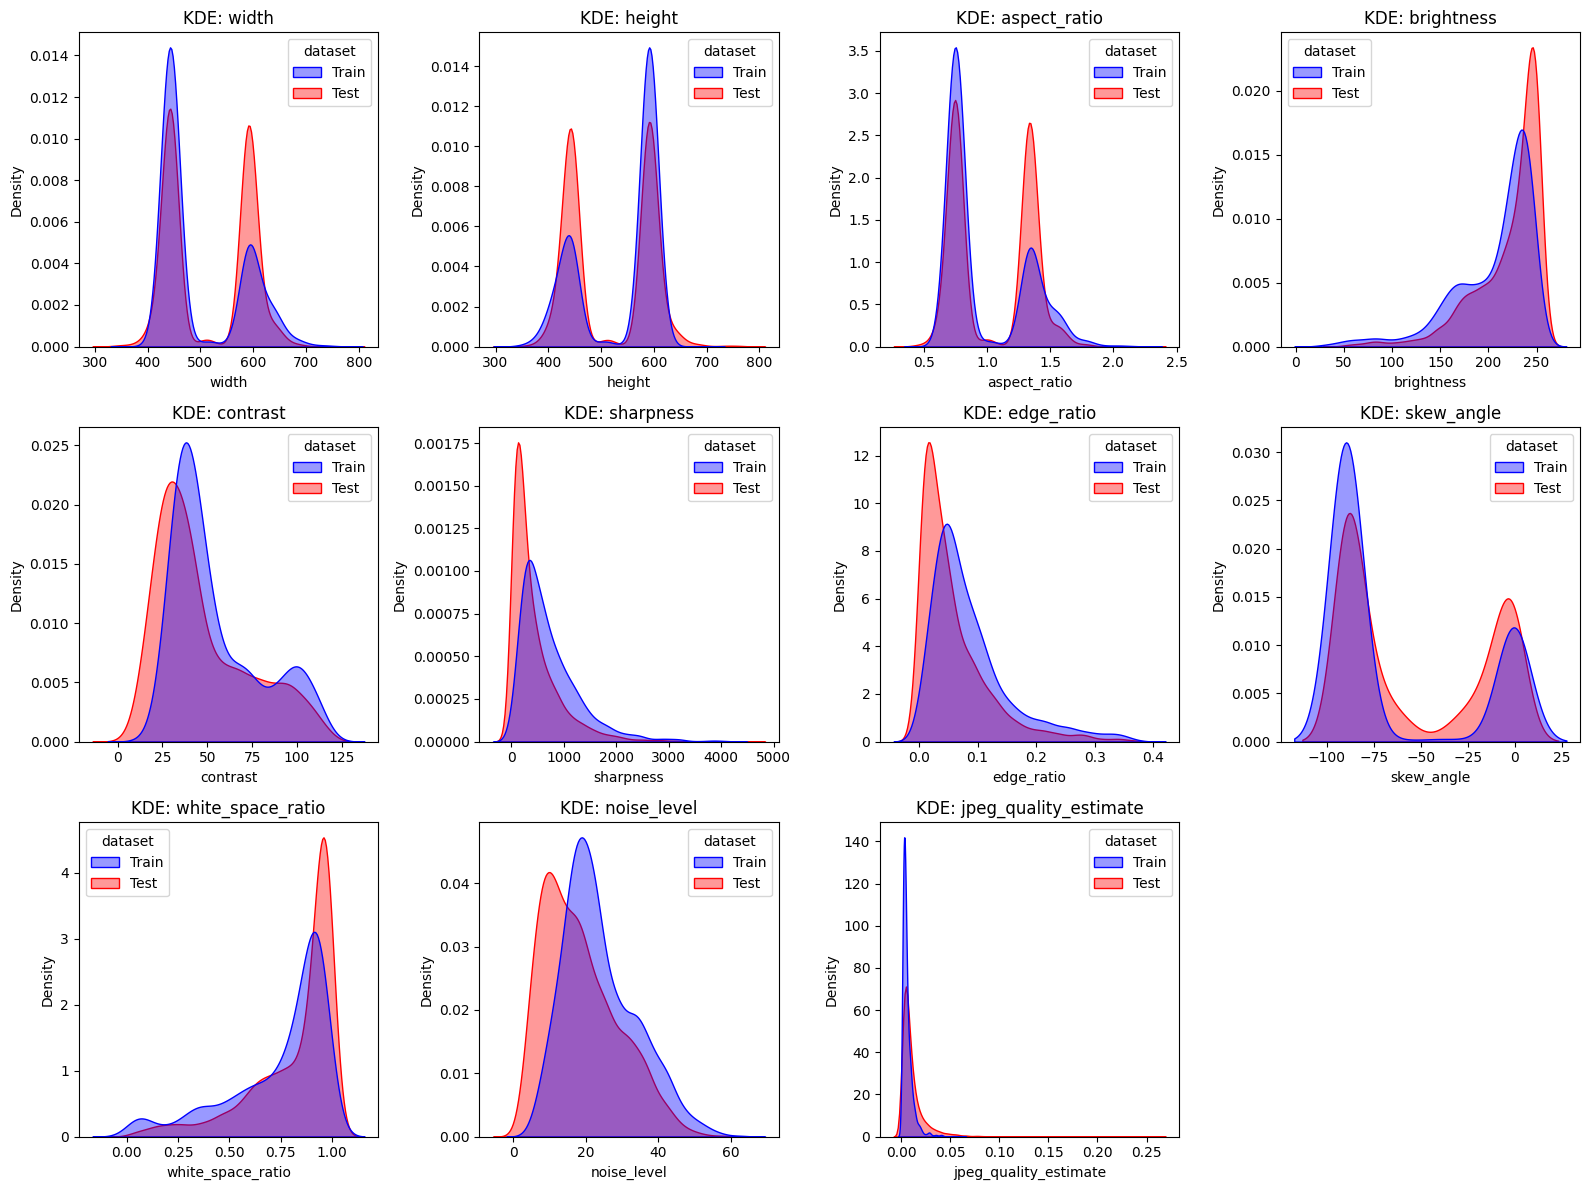

In [45]:
cols = 4
rows = int(np.ceil(len(features) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

axes = axes.flatten()  # 2D array -> 1D로 펼침

for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.kdeplot(
        data=df_all,
        x=feature,
        hue='dataset',
        fill=True,
        common_norm=False,
        alpha=0.4,
        palette={'Train': 'blue', 'Test': 'red'},
        ax=ax
    )
    ax.set_title(f'KDE: {feature}')

# 남은 빈 subplot 제거
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("train_test_kdeplot.jpg", dpi=300, bbox_inches='tight') #해상도 300, 여백 없이 저장
plt.show()


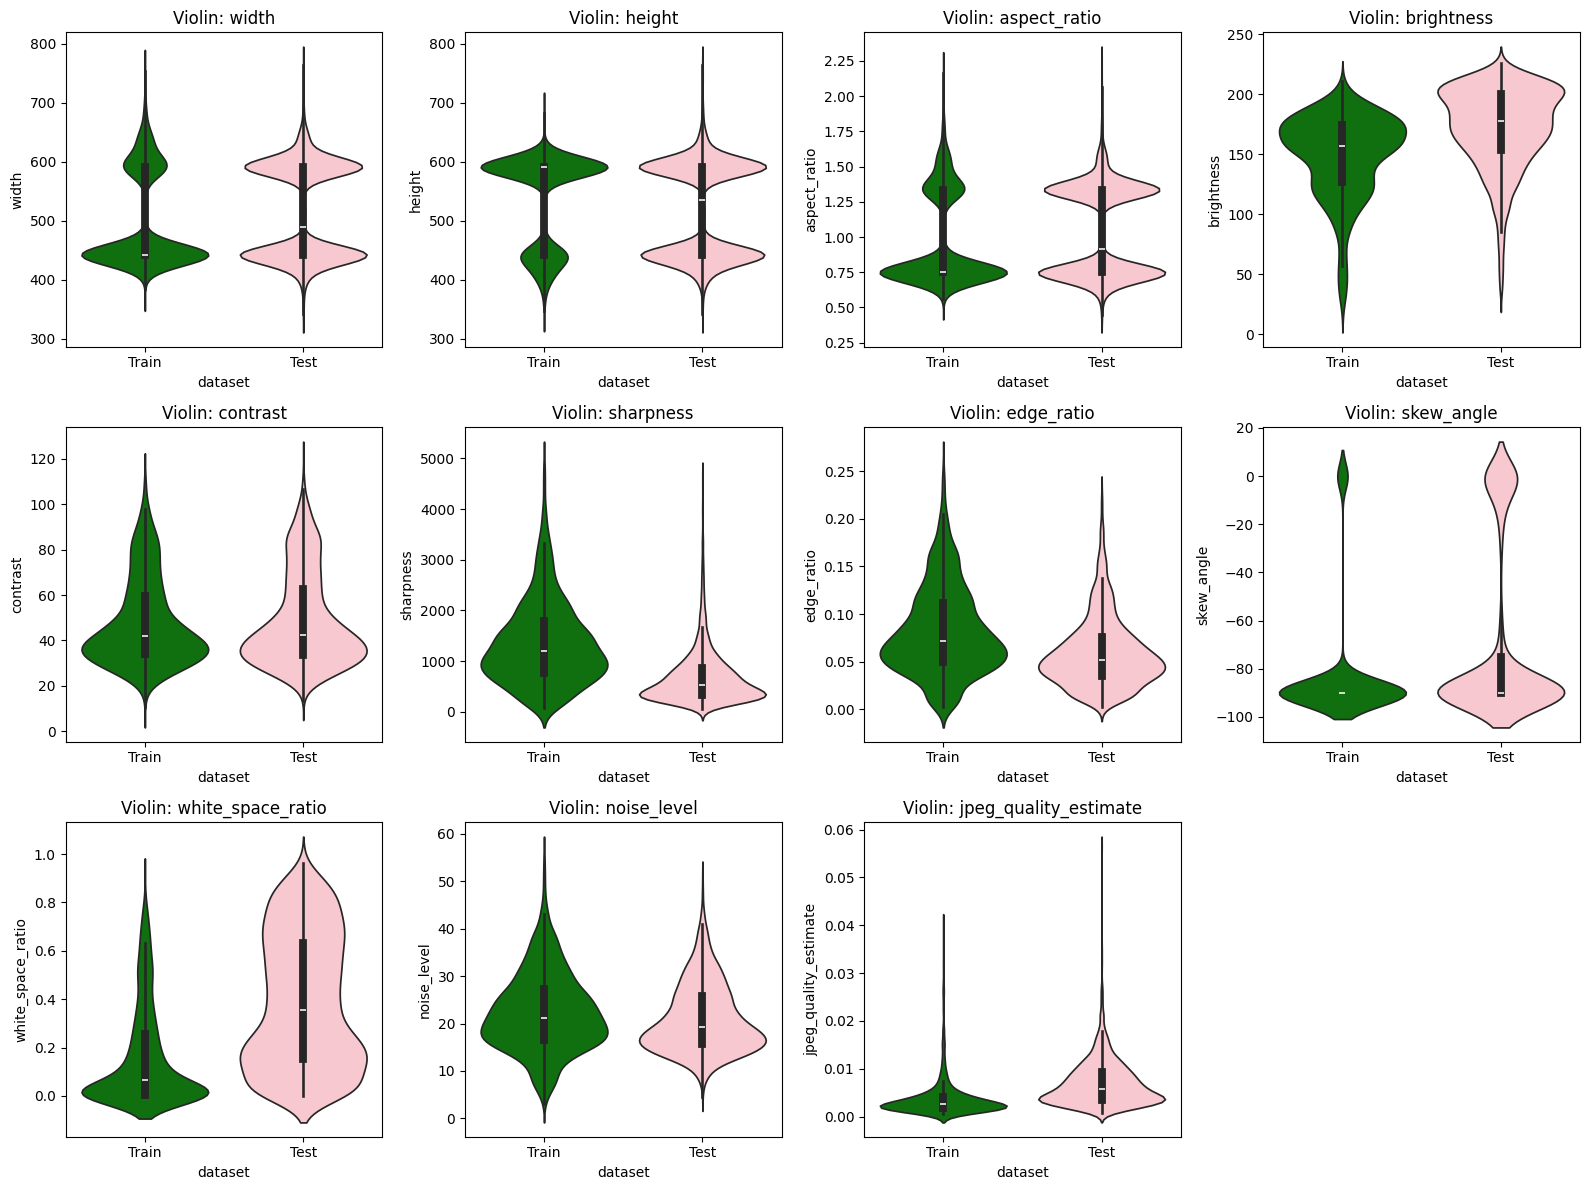

In [19]:
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

axes = axes.flatten()  # 2D array → 1D로 펼침

for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.violinplot(
        data=df_all,
        x='dataset',
        y=feature,
        hue='dataset',            
        palette={'Train': 'green', 'Test': 'pink'},
        inner='box',
        legend=False,             
        ax=ax
    )

    ax.set_title(f'Violin: {feature}')

# 남은 빈 subplot 제거
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("train_test_violinplot.jpg", dpi=300, bbox_inches='tight') #해상도 300, 여백 없이 저장
plt.show()